<a href="https://colab.research.google.com/github/mbibrahe/BA_Project/blob/main/FS_UNET%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
!git clone https://github.com/lim-eren/CDnet2014.git

Cloning into 'CDnet2014'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [ ]:
from __future__ import print_function
import glob, os, numpy as np
from keras.preprocessing import image as kImage
from __future__ import print_function
import numpy as np
import random as rn
import os
from tensorflow.compat.v1.keras import backend as K


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [ ]:


download = drive.CreateFile({'id': '1Wm5-hUo3g0iODGBJjTC1vzbO0UfubwSN'})
download.GetContentFile("first_sample_new.zip")


! unzip first_sample_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (155) - Copy - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (155) - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (155) - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (156) - Copy - Copy - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (156) - Copy - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (156) - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (156) - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (157) - Copy - Copy - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (157) - Copy - Copy - Copy - Copy.jpg  
  inflating: first_sample_new/train/z/2/full_bg2 - Copy (157) - Copy - Copy - Copy.jpg  
  inflating: first_sampl

In [ ]:
download = drive.CreateFile({'id': '13Ayf-z8-TocRv79skyWFq_KHTS9N97xb'})
download.GetContentFile("tester.zip")


! unzip tester.zip

Archive:  tester.zip
   creating: tester/test/
   creating: tester/test/x/
  inflating: tester/test/x/1_in000595.jpg  
  inflating: tester/test/x/1_in000604.jpg  
  inflating: tester/test/x/1_in000613.jpg  
  inflating: tester/test/x/2_in000460.jpg  
  inflating: tester/test/x/2_in000469.jpg  
  inflating: tester/test/x/2_in000478.jpg  
  inflating: tester/test/x/3_in000994.jpg  
  inflating: tester/test/x/3_in001003.jpg  
  inflating: tester/test/x/3_in001012.jpg  
  inflating: tester/test/x/in000400.jpg  
  inflating: tester/test/x/in000412.jpg  
  inflating: tester/test/x/in000700.jpg  
  inflating: tester/test/x/in000727.jpg  
  inflating: tester/test/x/in000847.jpg  
  inflating: tester/test/x/in000876.jpg  
  inflating: tester/test/x/in000886.jpg  
  inflating: tester/test/x/in000896.jpg  
  inflating: tester/test/x/in000918.jpg  
  inflating: tester/test/x/in000923.jpg  
  inflating: tester/test/x/in000933.jpg  
  inflating: tester/test/x/in000943.jpg  
  inflating: tester/test/

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling3D
from keras.models import Sequential
from keras.layers.convolutional import Deconv2D
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D, LayerNormalization, UpSampling2D, Conv2DTranspose
from keras.layers.merge import concatenate, Average
import keras.backend as K
import tensorflow as tf
from keras import regularizers
from keras.regularizers import l2

#Unet++: A Nested U-Net Architecture for Medical Image Segmentation
#Zhou, Zongwei and Siddiquee, Md Mahfuzur Rahman and Tajbakhsh, Nima and Liang, Jianming
#Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support
#2018
#https://github.com/MrGiovanni/UNetPlusPlus

smooth = 1.
dropout_rate = 0.5

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'relu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, kernel_initializer = 'he_normal', padding='same')(input_tensor)
    
    #x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, kernel_initializer = 'he_normal', padding='same')(x)
    

    return x

def unet_mod(input1_):

  nb_filter = [32,64,128,256,512]

  conv1_1 = standard_unit(input1_, stage='11', nb_filter=nb_filter[0]) #0,0 
  pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_1)
  

  conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1]) #1,0
  pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_1)

  up1_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_1) #0,1
  conv1_2 = concatenate([up1_2, conv1_1], axis=3)
  conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

  conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2]) #2,0
  pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_1)

  up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_1) #1,1
  conv2_2 = concatenate([up2_2, conv2_1], axis=3)
  conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])


  up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2) #0,2
  conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=3)
  conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])



  conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3]) #3,0
  pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_1)

  up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_1) #2,1
  conv3_2 = concatenate([up3_2, conv3_1], axis=3)
  conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])


  up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(conv3_2) #1,2
  conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=3)
  conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])


  up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(conv2_3) #0,3
  conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=3)
  conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])


  conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4]) #4,0


  up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), padding='same')(conv5_1) #3,1
  conv4_2 = concatenate([up4_2, conv4_1], axis=3)
  conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])


  up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), padding='same')(conv4_2) #2,2
  conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=3)
  conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])


  up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(conv3_3) #1,3
  conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=3)
  conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])


  up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(conv2_4) #0,4
  conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=3)
  conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])


  #Deep supervision

  #Try dense 2 layers before each dense 1


  nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
  nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
  nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
  nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
  

  


  con_ = tf.keras.layers.Average()([nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])
  #con_ = nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_5)
  con_ = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))(con_)



  return con_


In [ ]:
import numpy as np

import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling3D
from keras.models import Sequential
from keras.layers.convolutional import Deconv2D
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D, LayerNormalization, UpSampling2D, Conv2DTranspose
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf
from keras import regularizers
from PIL import Image as PILimage
import matplotlib.pyplot as plt
from matplotlib import image as imageMat
from keras import backend as K
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as Image
from sklearn.utils import class_weight
from sklearn import metrics
import cv2 as cv
import math
#import torch
  


#Use tensorflow 2.0!!
#Softmax
#Dont save in .JPG!
#Stay with .png or numpy array

# load data
dataset_path = os.path.join('first_sample_new')
#dataset_path = os.path.join('Full_test_1_40samples')
def getData(dataset_dir):
    
    
    

    #Run for less frames
    X_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'x','*','*.jpg')))
    
    

    Y_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'y','*','*.png')))
    


    Z_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'z','*','*.jpg')))



    X= []
    Y= []
    Z= []

    

    print(len(X_list))
    
    for i in range(0, len(X_list)):
        # Load input image
        

        x1 = cv.resize(cv.imread(X_list[i]), (320, 240))
        normalizedImg1 = np.zeros((320, 240))
        normalizedImg1 = cv.normalize(x1,  normalizedImg1, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg1)
      
        
        x = cv.resize(cv.imread(Y_list[i], 0), (320, 240))
        x = cv.normalize(x, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        Y.append(x)


        z1 = cv.resize(cv.imread(Z_list[i]), (320, 240))
        normalizedImg1 = np.zeros((320, 240))
        normalizedImg1 = cv.normalize(z1,  normalizedImg1, 0, 255, cv.NORM_MINMAX)
        Z.append(normalizedImg1)
        
        

     

    
    
    
            
    X = np.asarray(X)
    Y = np.asarray(Y)
    Z = np.asarray(Z)
    #print(X.shape)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    Z = Z[idx]

    #måske Z her
    return X, Y, Z




X, Y, Z = getData(dataset_path)

"""for i in range(0,10):
  plt.imshow(X[i])
  plt.show()
  plt.imshow(Y[i])
  plt.show()
  plt.imshow(Z[i])
  plt.show()"""

# init the model

tf.random.set_seed(8)

def initModel():
    
    
    img_1 = Input(shape=(None, None ,3))
    img_2 = Input(shape=(None, None ,3))
    

    
    # We Average the input image, and the background image
    out1 = unet_mod(img_1)
    out2 = unet_mod(img_2)
   
    x = tf.keras.layers.Average()([out1, out2])

    #x = concatenate([out1, out2], axis=-1)

    #x = Dense(4)(x)
    x = Dense(2)(x)

    out_d = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))(x)
    
    #Try to output x only

    
    model = Model([img_1, img_2], outputs=out_d)
    model.summary()


    """lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-6,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)"""

    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.0025)
    """model.compile(optimizer="rmsprop", 
              loss=bce_dice_loss, 
              metrics=['accuracy'])"""



    
    
    return model



    


model = initModel()


patches_bi = []
patches_in = []
patches_bt = []


# Stacking the background image and input images, for every frame

patch_size = (32, 32)

for i in range(len(X)):
    data_in = Image.extract_patches_2d(X[i], patch_size, max_patches=90, random_state=1)
    data_bt = Image.extract_patches_2d(Y[i], patch_size, max_patches=90, random_state=1)
    data_bi = Image.extract_patches_2d(Z[i], patch_size, max_patches=90, random_state=1)
    patches_in.append(data_in)
    patches_bt.append(data_bt)
    patches_bi.append(data_bi)




patches_in = np.concatenate(patches_in)
patches_bt = np.concatenate(patches_bt)
patches_bi = np.concatenate(patches_bi)


print(patches_in.shape)







#1. Complete fitting first

#We need to train on more pictures

# Training should be stopped if error < 3
"""weights = class_weight.compute_class_weight('balanced',
                                            np.unique(patches_bt),
                                            patches_bt)"""

#Stagnates at 107 epochs                                             
model.fit([patches_in, patches_bi], y=patches_bt, batch_size=600, epochs=60, verbose=1, validation_split=0.2, shuffle=True)


model.save('my_model.h5')




10275
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, None, 3 896         input_2[0][0]                    
________________________________________________________________________________________

(35, 240, 320, 3)
(35, 240, 320)
35/35 [==============================] - 1s 16ms/step
tf.Tensor(0.7934022, shape=(), dtype=float32)


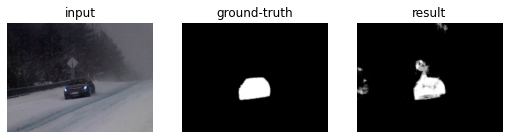

In [ ]:
#from keras import tensor as tf

dataset_path = os.path.join('tester', 'test')
def getData_test(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    
    X= []
    Y= []
    
    for i in range(0, len(X_list)):
        # Load input image
        x = cv.resize(cv.imread(X_list[i]), (320, 240))
        normalizedImg = np.zeros((320, 240))
        normalizedImg = cv.normalize(x,  normalizedImg, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg)
        
        # Load ground-truth label and encode to value 0 and 1
        y = cv.resize(cv.imread(Y_list[i], 0), (320, 240))
        y = cv.normalize(y, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        Y.append(y)

        # Load input image
        """x = cv.imread(X_list[i])
        print(x.shape)
        #normalizedImg = np.zeros((320, 240))
        #normalizedImg = cv.normalize(x, 0, 255, cv.NORM_MINMAX)
        X.append(x)
        
      
        
        
        #X.append(normalizedImg1)
        y = cv.imread(Y_list[i], 0)
        y = cv.normalize(y, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        Y.append(y)"""


        
            
    X = np.asarray(X)
    print(X.shape)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    """idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]"""

    return X, Y
X, Y = getData_test(dataset_path)

print(Y.shape)



#2. Prediction 
pred = model.predict([X,X], verbose=1, batch_size=1)




plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = 31 # image index in a range of [0,9]

img = np.empty(3, dtype=object)
img[0] = X[idx]
img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])

img[2] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])

#img[2] = cv2.medianBlur(pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1]), 5)

"""t_img = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])
m, n = t_img
   
# Develop Averaging filter(3, 3) mask 
mask = np.ones([3, 3], dtype = int) 
mask = mask / 9
   
# Convolve the 3X3 mask over the image  
img_new = np.zeros([m, n]) 
  
for i in range(1, m-1): 
    for j in range(1, n-1): 
        temp = t_img[i-1, j-1]*mask[0, 0]+t_img[i-1, j]*mask[0, 1]+t_img[i-1, j + 1]*mask[0, 2]+t_img[i, j-1]*mask[1, 0]+ t_img[i, j]*mask[1, 1]+t_img[i, j + 1]*mask[1, 2]+t_img[i + 1, j-1]*mask[2, 0]+t_img[i + 1, j]*mask[2, 1]+t_img[i + 1, j + 1]*mask[2, 2] 
         
        img_new[i, j]= temp 
          
img_new = img_new.astype(np.uint8) 
#cv2.imwrite('blurred.tif', img_new) 

img[3] = img_new
"""





def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

print(dice_coef(Y[idx], pred[idx]))

title = ['input', 'ground-truth', 'result']
for i in range(3):
  plt.subplot(1, 4, i+1)
  if i==0:
    plt.imshow(img[i].astype('uint8'))
  else:
    plt.imshow(img[i], cmap='gray')
  
  plt.axis('off')
  plt.title(title[i])


plt.show()



